In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
try:
    from enlighten_inference import EnlightenOnnxModel
except ImportError:
    !pip install git+https://github.com/arsenyinfo/EnlightenGAN-inference
    from enlighten_inference import EnlightenOnnxModel
import kornia
from kapture_localization.matching.matching import MatchPairNnTorch
from torch.nn.functional import grid_sample
import torch

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/home/andrei/miniconda3/envs/enGAN/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data

In [3]:
img_1_path = "data/light/images/1635955578360077142.png"
img_2_path = "data/light/images/1635955578624037742.png"

In [4]:
def read_image_and_convert_to_gray(image):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [5]:
img_1, gray_image_1 = read_image_and_convert_to_gray(img_1_path)
img_2, gray_image_2 = read_image_and_convert_to_gray(img_2_path)

### Process images

In [6]:
def process_image_by_gun(image):
    model = EnlightenOnnxModel()
    img = cv2.imread(image)
    processed_img = model.predict(img)
    processed_gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
    return processed_img, processed_gray

In [7]:
processed_img_1, gray_processed_image_1 = process_image_by_gun(img_1_path)
processed_img_2, gray_processed_image_2 = process_image_by_gun(img_2_path)

### Ectarct features

In [8]:
def orb_feature_exctraction(img):
    orb = cv2.ORB_create()
    kp, descr = orb.detectAndCompute(img, None)
    orb_img = cv2.drawKeypoints(img, kp, None)
    return orb_img, kp, descr

def sift_feature_exctraction(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, descr = sift.detectAndCompute(img, None)
    sift_img = cv2.drawKeypoints(img, kp, None)
    return sift_img, kp, descr

In [9]:
orb_img_1, orb_keypoints_1, orb_descriptors_1 = orb_feature_exctraction(img_1)
orb_img_2, orb_keypoints_2, orb_descriptors_2 = orb_feature_exctraction(img_2)

orb_processed_img_1, orb_processed_keypoints_1, orb_processed_descriptors_1 = orb_feature_exctraction(processed_img_1)
orb_processed_img_2, orb_processed_keypoints_2, orb_processed_descriptors_2 = orb_feature_exctraction(processed_img_2)

In [10]:
sift_img_1, sift_keypoints_1, sift_descriptors_1 = sift_feature_exctraction(img_1)
sift_img_2, sift_keypoints_2, sift_descriptors_2 = sift_feature_exctraction(img_2)

sift_processed_img_1, sift_processed_keypoints_1, sift_processed_descriptors_1 = sift_feature_exctraction(processed_img_1)
sift_processed_img_2, sift_processed_keypoints_2, sift_processed_descriptors_2 = sift_feature_exctraction(processed_img_2)

### Fundametnal matrix matching

In [63]:
def extract_orb_key_points_coordinates(orb_keypoints_1, orb_keypoints_2):
    orb_keypoints_1_x_y = []
    orb_keypoints_2_x_y = []
    for points in orb_keypoints_1:
        orb_keypoints_1_x_y.append(list(points.pt))
    for points in orb_keypoints_2:
        orb_keypoints_2_x_y.append(list(points.pt))
    return np.asarray(orb_keypoints_1_x_y), np.asarray(orb_keypoints_2_x_y)

def feature_matching(descriptors_1, descriptors_2, norm):
    bf = cv2.BFMatcher(norm, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    return matches

def extract_data(matches):
    matches_dist = []
    matches_queryIdx = []
    matches_trainIdx = []
    for points in matches:
        matches_dist.append(int(points.distance))
        matches_queryIdx.append(int(points.queryIdx))
        matches_trainIdx.append(int(points.trainIdx))
    return matches_dist, matches_queryIdx, matches_trainIdx
        
def matched_keypoints(keypoints_1_x_y, keypoints_2_x_y,
                      matches_queryIdx, matches_trainIdx, matches_dist):
    matched_keypoints1 = []
    matched_keypoints2 = []
    i = 0 
    for match in matches_dist:
        matched_keypoints1.append(keypoints_1_x_y[int(matches_queryIdx[i])])
        matched_keypoints2.append(keypoints_2_x_y[int(matches_trainIdx[i])])
        i = i + 1

    return np.array(matched_keypoints1), np.array(matched_keypoints2)

In [64]:
orb_keypoints_1_x_y, orb_keypoints_2_x_y = extract_orb_key_points_coordinates(orb_keypoints_1, orb_keypoints_2)
orb_matches = feature_matching(orb_descriptors_1, orb_descriptors_2, cv2.NORM_HAMMING)
orb_matches_dist, orb_matches_queryIdx, orb_matches_trainIdx = extract_data(orb_matches)
orb_matched_keypoints1, orb_matched_keypoints2 = matched_keypoints(orb_keypoints_1_x_y, orb_keypoints_2_x_y,
                                                                   orb_matches_queryIdx, orb_matches_trainIdx,
                                                                   orb_matches_dist)

In [65]:
sift_keypoints_1_x_y, sift_keypoints_2_x_y = extract_orb_key_points_coordinates(sift_keypoints_1, sift_keypoints_2)
sift_matches = feature_matching(sift_descriptors_1, sift_descriptors_2, cv2.NORM_L2)
sift_matches_dist, sift_matches_queryIdx, sift_matches_trainIdx = extract_data(sift_matches)
sift_matched_keypoints1, sift_matched_keypoints2 = matched_keypoints(sift_keypoints_1_x_y, sift_keypoints_2_x_y,
                                                                     sift_matches_queryIdx, sift_matches_trainIdx,
                                                                     sift_matches_dist)

### Next part


In [66]:
def plot_fundmental_matrix_matching(img1, img2,
                                    matched_keypoints1, matched_keypoints2,
                                    keypoints_1_x_y, keypoints_2_x_y,
                                    matches, title, i=0
                                   ):

    fundamental_matrix, mask = cv2.findFundamentalMat(matched_keypoints1, matched_keypoints2, cv2.UsacParams())
    
    plt.figure(dpi=200)
    output_image = np.concatenate([img_1, img_2], axis=1)
    plt.imshow(output_image)
    plt.scatter(keypoints_1_x_y[:, 0], keypoints_1_x_y[:, 1], s=1)
    plt.scatter(keypoints_2_x_y[:, 0] + 640, keypoints_2_x_y[:, 1], s=1)
    i=0
    for points in matches:
        color = "green" if mask[i, 0] else "red" 
        i = i + 1
        plt.plot([keypoints_1_x_y[int(points.queryIdx), 0], keypoints_2_x_y[int(points.trainIdx), 0] + 640], 
                 [keypoints_1_x_y[int(points.queryIdx), 1], keypoints_2_x_y[int(points.trainIdx), 1]], linewidth=1, c=color)   
    plt.title(title);
    plt.axis('off');

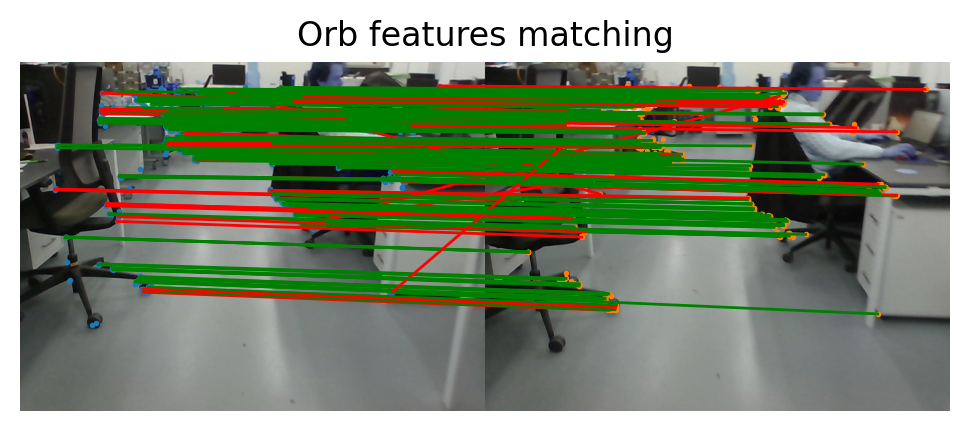

In [67]:
plot_fundmental_matrix_matching(img_1, img_2,
                                orb_matched_keypoints1, orb_matched_keypoints2,
                                orb_keypoints_1_x_y, orb_keypoints_2_x_y,
                                orb_matches, title='Orb features matching'
                               )

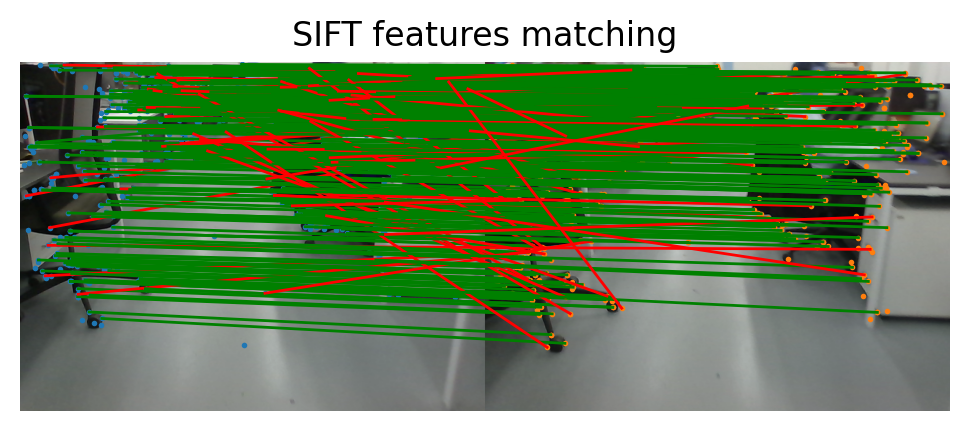

In [69]:
plot_fundmental_matrix_matching(img_1, img_2,
                                sift_matched_keypoints1, sift_matched_keypoints2,
                                sift_keypoints_1_x_y, sift_keypoints_2_x_y,
                                sift_matches, title='SIFT features matching'
                               )